# Heart Disease Prediction – Machine Learning Pipeline

## Objective
The goal of this project is to develop and evaluate machine learning models
for predicting the presence of heart disease using clinical features.
Given the medical nature of the dataset, emphasis is placed on:
- ROC-AUC
- Recall (Sensitivity)
- Model interpretability


## Imports & setup



In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import joblib

plt.style.use("default")


## Load the Dataset


In [2]:
DATA_PATH = Path("heart.csv")
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Initial Data Inspection



In [3]:
df.info()
print("\nMissing values:")
print(df.isna().sum())

print("\nTarget distribution:")
print(df["target"].value_counts())
print(df["target"].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dty

## Exploratory Data Analysis (EDA)


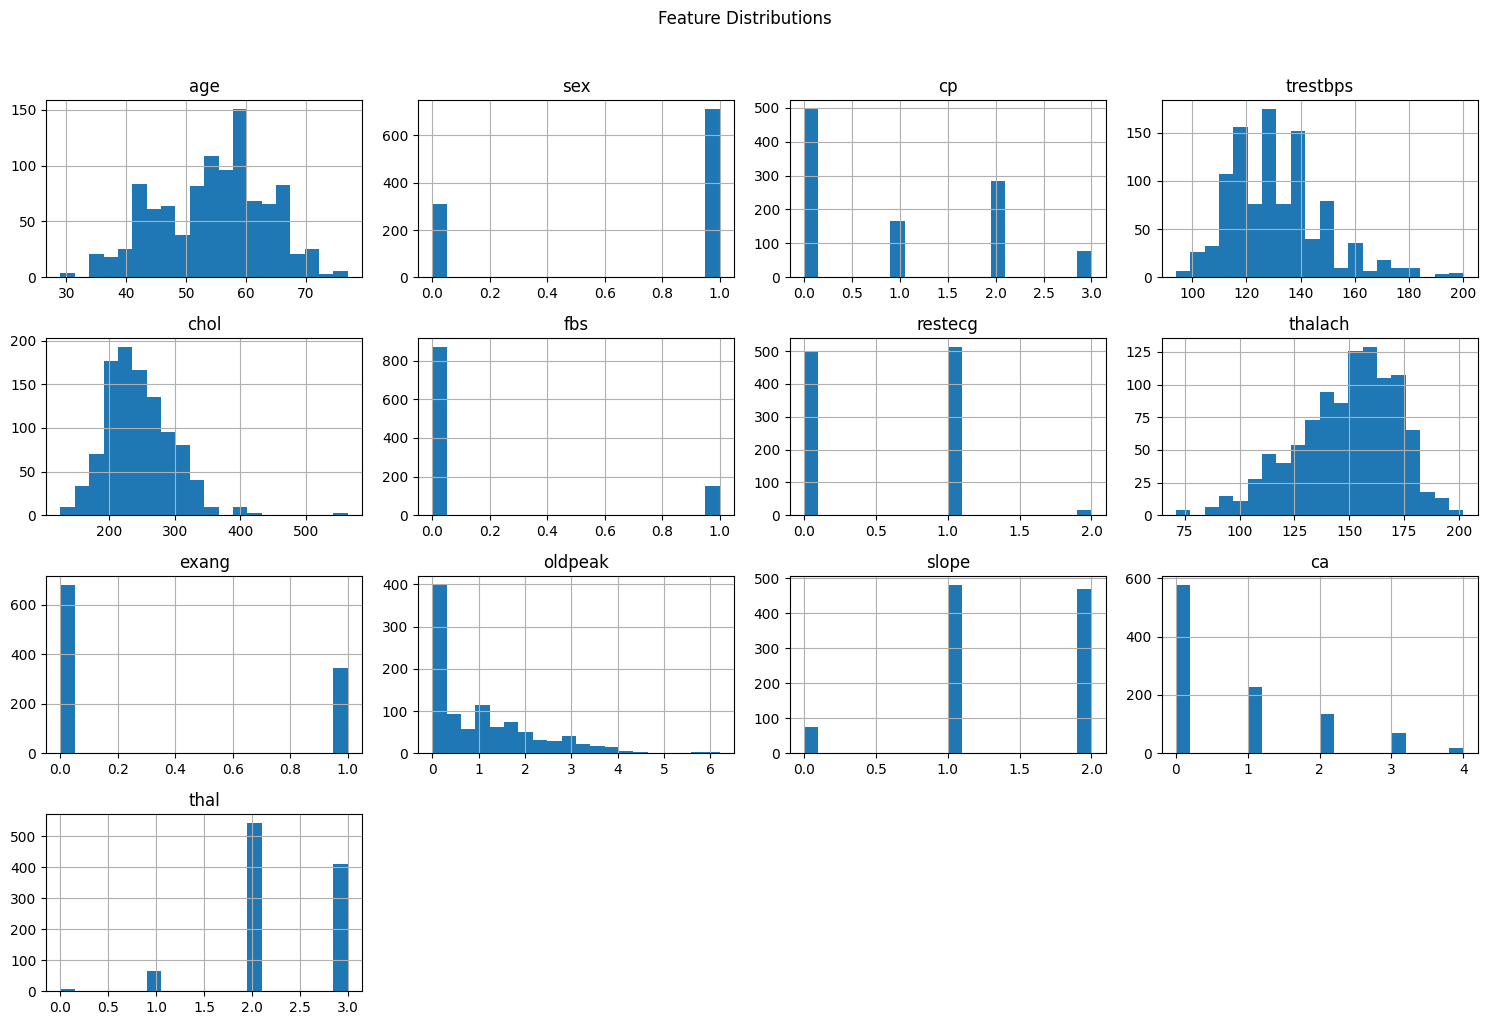

In [4]:
df.drop(columns="target").hist(figsize=(15, 10), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


## Feature–Target Correlation


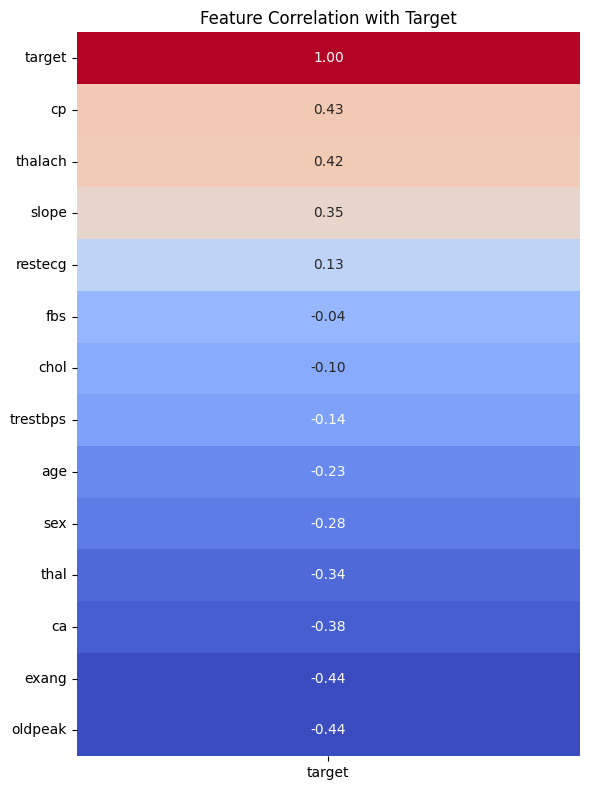

In [5]:
corr = df.corr()["target"].sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False
)
plt.title("Feature Correlation with Target")
plt.tight_layout()
plt.show()


## Data Cleaning


In [6]:
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

if duplicates > 0:
    df = df.drop_duplicates()


Duplicate rows: 723


## Train–Test Split


In [7]:
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (241, 13)
Test shape: (61, 13)


## Baseline Models & Cross-Validation

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", RobustScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(
            random_state=42,
            class_weight="balanced"
        ))
    ]),
    "SVC": Pipeline([
        ("scaler", RobustScaler()),
        ("clf", SVC(
            probability=True,
            class_weight="balanced",
            random_state=42
        ))
    ])
}

for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    print(f"{name}: mean ROC-AUC = {scores.mean():.4f}")


Logistic Regression: mean ROC-AUC = 0.9152
Random Forest: mean ROC-AUC = 0.9043
SVC: mean ROC-AUC = 0.9146


## Hyperparameter Tuning

### Logistic Regression


In [9]:
param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    pipelines["Logistic Regression"],
    param_grid_lr,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

print("Best LR params:", grid_lr.best_params_)


Best LR params: {'clf__C': 1}


### Random Forest

In [10]:
param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    pipelines["Random Forest"],
    param_grid_rf,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


### SVC


In [11]:
param_grid_svc = [
    {"clf__kernel": ["linear"], "clf__C": [0.1, 1, 10]},
    {"clf__kernel": ["rbf"], "clf__C": [0.1, 1, 10], "clf__gamma": ["scale", 0.1]}
]

grid_svc = GridSearchCV(
    pipelines["SVC"],
    param_grid_svc,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_svc.fit(X_train, y_train)
best_svc = grid_svc.best_estimator_


## Test Set Evaluation



In [12]:
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "SVC": best_svc
}

for name, model in models.items():
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{name} Test ROC-AUC: {auc:.4f}")


Logistic Regression Test ROC-AUC: 0.8766
Random Forest Test ROC-AUC: 0.8636
SVC Test ROC-AUC: 0.8658


## Final Model Selection

Logistic Regression was selected as the final model due to:
- Comparable ROC-AUC performance
- Higher interpretability
- Suitability for medical decision-making


In [13]:
final_model = best_lr


## Final Evaluation

In [14]:
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

print("Final Test ROC-AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))


Final Test ROC-AUC: 0.8766233766233767
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        28
           1       0.82      0.82      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



## Confusion Matrix

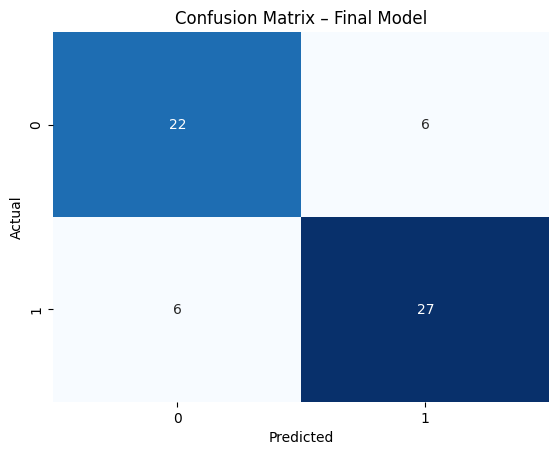

In [15]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Final Model")
plt.show()


## ROC Curve


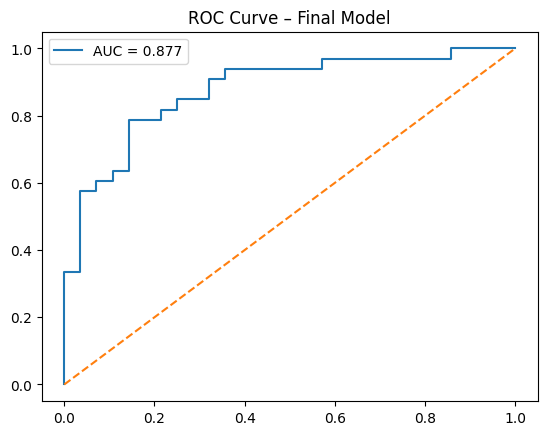

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()
plt.title("ROC Curve – Final Model")
plt.show()


## Model Persistence


In [17]:
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(final_model, MODEL_DIR / "final_model.pkl")
print("Model saved successfully.")


Model saved successfully.
